- Objective: Many finetuned models (adept at diff tasks) that use one common base model
- If not LoRAs: We will have to do separate deployment per task which is very costly

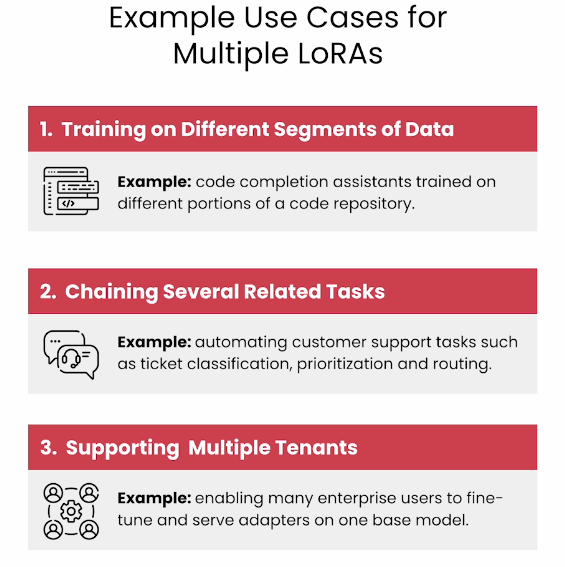

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm

## Toy model

In [3]:
class AbstractMultiLoraModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # hidden_size = 10
        # set this so low to ensure we are not 
        # compute-bound by the linear layer
        # this is only an issue when running on CPU, 
        # for GPUs we can set this much
        # higher and still avoid being compute bound
        self.embedding = torch.nn.Embedding(10, 10)
        self.linear = torch.nn.Linear(10, 10)
        self.lm_head = torch.nn.Linear(10, 10)

    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, rank)
        loras_b: torch.Tensor,           # (num_loras, rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        # y[i] = x[i] @ loras_a[lora_idx] @ loras_b[lora_idx]
        raise NotImplementedError()

    def forward(self, input_ids, loras_a, loras_b, lora_indices):
        x = self.embedding(input_ids)
        x = self.linear_lora(x, loras_a, loras_b, lora_indices) # switch loras based on the task
        x = self.lm_head(x)
        return x

Using a loop: just loop over every row in the batch and apply the correct LoRA using an index mapping: batch_index --> lora_index.

In [4]:
class LoopMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        for batch_idx, lora_idx in enumerate(lora_indices.numpy()):
            lora_a = loras_a[lora_idx]
            lora_b = loras_b[lora_idx]
            y[batch_idx] += x[batch_idx] @ lora_a @ lora_b
        return y

In [5]:
# toy example of a detokenizer. The vocabular only consists of 10 words (different colors)
detokenizer = [
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "indigo",
    "violet",
    "magenta",
    "marigold",
    "chartreuse",
]

In [6]:
# dummy inputs
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])

In [7]:
torch.manual_seed(42)

In [8]:
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [9]:
model = LoopMultiLoraModel()

## Random LoRA

ew random LoRAs using a fixed tensor of input_ids. If our multi-LoRA generation process is working as designed, we should see a variety of different outputs generated as we randomly iterate over the LoRAs.

In [11]:
# constants
bs = 1
num_loras = 64
h = 10
r = 2

# create contiguous blocks for 64 random LoRA weights
loras_a = torch.randn(num_loras, h, r)
loras_b = torch.randn(num_loras, r, h)

for i in range(10):
    # randomize the LoRAs each iteration
    lora_indices = torch.randint(num_loras, (bs,), dtype=torch.long)
    print(lora_indices)
    next_token = generate_token(
        model,
        input_ids=input_ids,
        loras_a=loras_a,
        loras_b=loras_b,
        lora_indices=lora_indices,
    )
    print(next_token)

tensor([25])
['orange']
tensor([39])
['green']
tensor([8])
['orange']
tensor([54])
['blue']
tensor([4])
['green']
tensor([55])
['chartreuse']
tensor([31])
['blue']
tensor([19])
['red']
tensor([49])
['indigo']
tensor([10])
['indigo']


In [13]:
generate_token(
    model,
    input_ids=input_ids,
    loras_a=loras_a,
    loras_b=loras_b,
    lora_indices=torch.tensor([10]),
)

['indigo']

In [14]:
loras_a.shape, loras_b.shape

(torch.Size([64, 10, 2]), torch.Size([64, 2, 10]))

## Benchmarking

measure the average latency to generate a single token as the batch size increases and each element within the batch can have a different LoRA adapter (chosen randomly).

In [15]:
# constants
seq_len = 8
vocab_size = 10
nsamples = 500
max_batch_size = 64


def benchmark(model):
    avg_latencies = []
    for bs in range(1, max_batch_size + 1):
        latencies = []
        for _ in range(nsamples):
            # randomize the inputs and LoRA indices
            input_ids = torch.randint(
                vocab_size, (bs, seq_len), dtype=torch.long)
            lora_indices = torch.randint(
                num_loras, (bs,), dtype=torch.long)

            # measure the end-to-end latency for 
            # generating a single token
            t0 = time.time()
            next_token = generate_token(
                model,
                input_ids=input_ids,
                loras_a=loras_a,
                loras_b=loras_b,
                lora_indices=lora_indices,
            )
            latencies.append(time.time() - t0)

        # average the latency across all the samples
        latency_s = sum(latencies) / len(latencies)
        avg_latencies.append(latency_s)
        print(bs, latency_s)
    return avg_latencies

In [16]:
avg_latencies_loop = benchmark(model)

1 0.00016140317916870118
2 0.00018666982650756837
3 0.00026983880996704103
4 0.0002465252876281738
5 0.0002856326103210449
6 0.00042860746383666993
7 0.000346376895904541
8 0.0003616294860839844
9 0.00042807531356811525
10 0.0004690413475036621
11 0.00046517610549926756
12 0.0004893350601196289
13 0.0005269560813903808
14 0.0005265698432922363
15 0.0005666389465332031
16 0.0006055927276611328
17 0.0006367416381835938
18 0.000651498794555664
19 0.0007950682640075683
20 0.000746957778930664
21 0.0008521757125854492
22 0.0007876338958740234
23 0.0007754192352294922
24 0.000778268814086914
25 0.0008923354148864746
26 0.0009125509262084961
27 0.0010057244300842286
28 0.0009992046356201172
29 0.001020595073699951
30 0.0009990930557250977
31 0.0010092959403991699
32 0.001042989730834961
33 0.001076117992401123
34 0.0011260771751403808
35 0.0012384042739868163
36 0.0015785388946533204
37 0.0014941282272338868
38 0.0013549599647521972
39 0.001492678165435791
40 0.0014912824630737304
41 0.001421

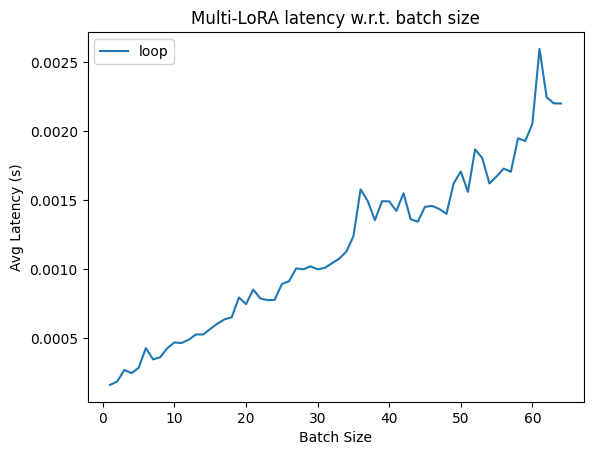

In [17]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()

- As batch size increases -> latency also increases

## Vectorize LoRA computations

Instead of multiplying lora vectors one by one we can multiply all at once by stacking lora vectors based on required indexes.

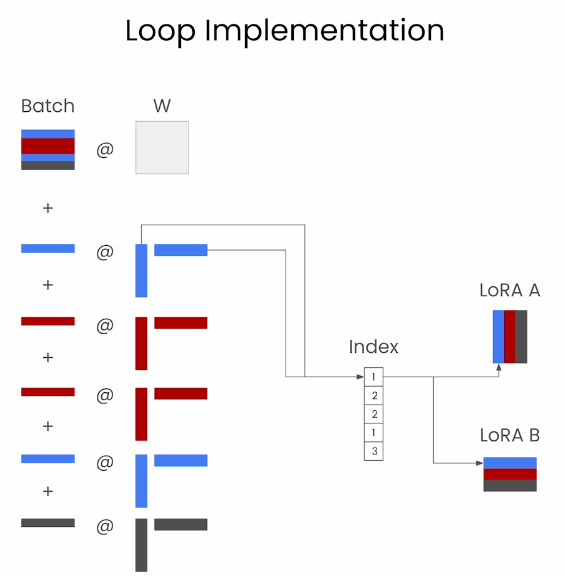
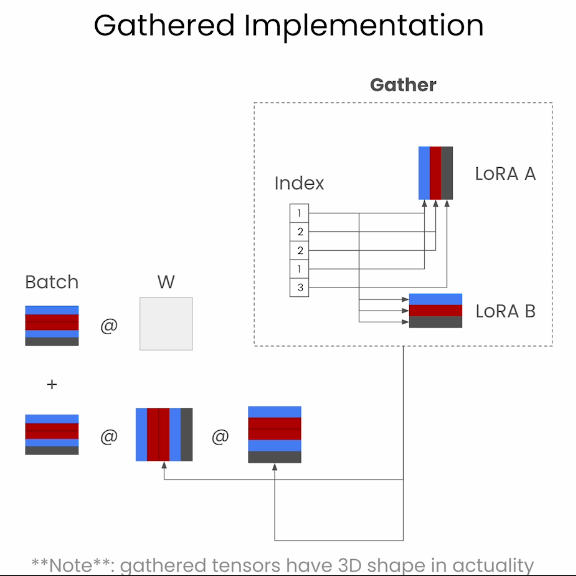

Vectorize LoRA computations by:
1. Gather the LoRA weight for each batch into a single tensor using torch.index_select.
2. Apply LoRA computation once for the entire input tensor.

In [18]:
class GatheredMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        
        # gather the LoRA weights into a new tensor and apply
        lora_a = torch.index_select(loras_a, 0, lora_indices) # (batch_size, in_features, lora_rank)
        lora_b = torch.index_select(loras_b, 0, lora_indices) # (batch_size, lora_rank, out_features)
        y += x @ lora_a @ lora_b
        return y

# below for comparison
class LoopMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        for batch_idx, lora_idx in enumerate(lora_indices.numpy()):
            lora_a = loras_a[lora_idx]
            lora_b = loras_b[lora_idx]
            y[batch_idx] += x[batch_idx] @ lora_a @ lora_b
        return y

In [19]:
model = GatheredMultiLoraModel()

In [20]:
avg_latencies_gathered = benchmark(model)

1 0.00018479633331298828
2 0.00012766599655151368
3 0.00018815755844116212
4 0.00017906713485717774
5 0.00018664121627807618
6 0.00027042198181152343
7 0.00017598819732666016
8 0.0001683664321899414
9 0.00018172359466552733
10 0.00018783378601074219
11 0.00019666433334350586
12 0.0001957392692565918
13 0.00020871353149414063
14 0.0002000412940979004
15 0.00021830368041992186
16 0.0002112264633178711
17 0.00021162176132202148
18 0.00021281147003173828
19 0.00020360136032104492
20 0.00022778034210205078
21 0.0002184157371520996
22 0.0002138671875
23 0.0002194395065307617
24 0.00023694753646850587
25 0.00025142669677734374
26 0.00028156375885009764
27 0.00024097585678100586
28 0.0002571988105773926
29 0.00025766611099243164
30 0.00030352592468261717
31 0.00029427528381347656
32 0.00027453804016113284
33 0.0002868280410766602
34 0.0003065085411071777
35 0.0002651042938232422
36 0.00026832771301269533
37 0.00031103515625
38 0.000249509334564209
39 0.0005167040824890137
40 0.0004180784225463

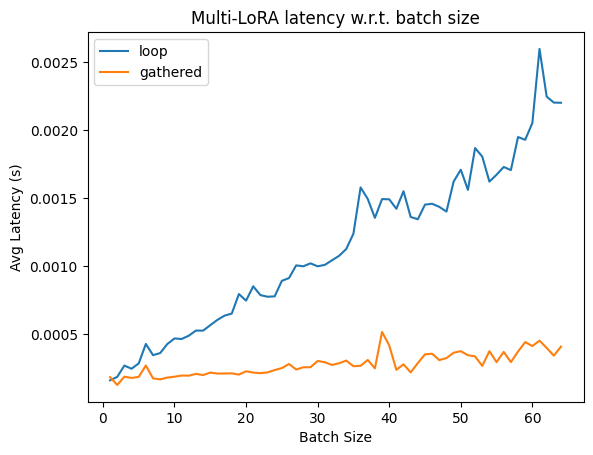

In [21]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")
plt.plot(x, avg_latencies_gathered, label="gathered")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()

## Test

In [26]:
bs = 32
seq_len = 8

In [27]:
input_ids = torch.randint(
    vocab_size, (bs, seq_len), dtype=torch.long)
lora_indices = torch.randint(
    num_loras, (bs,), dtype=torch.long)

In [28]:
lora_indices

tensor([14, 57, 27, 36, 47, 50, 27, 37, 48, 18, 31, 55, 49, 24, 49,  9, 12,  6,
        16, 14, 11, 62, 63, 45, 46,  6, 61, 44, 55, 38, 45, 38])

In [36]:
lora_indices[19]

tensor(14)

In [30]:
loras_a.shape, loras_b.shape

(torch.Size([64, 10, 2]), torch.Size([64, 2, 10]))

In [31]:
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [37]:
class GatheredMultiLoraModel1(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        print('Y Shape', y.shape)
        # gather the LoRA weights into a new tensor and apply
        lora_a = torch.index_select(loras_a, 0, lora_indices) # (batch_size, in_features, lora_rank)
        lora_b = torch.index_select(loras_b, 0, lora_indices) # (batch_size, lora_rank, out_features)
        
        print(lora_a.shape, lora_b.shape)
        print('sample Loras test')
        print(lora_a[0])
        print(lora_a[19])      
        y += x @ lora_a @ lora_b
        return y

In [38]:
model = GatheredMultiLoraModel1()

In [39]:
next_token = generate_token(
                model,
                input_ids=input_ids,
                loras_a=loras_a,
                loras_b=loras_b,
                lora_indices=lora_indices,
            )

Y Shape torch.Size([32, 8, 10])
torch.Size([32, 10, 2]) torch.Size([32, 2, 10])
sample Loras test
tensor([[-1.2760,  0.5217],
        [ 0.3298,  0.2811],
        [ 0.6924, -0.8060],
        [ 1.8508, -1.2886],
        [ 0.1854,  1.7064],
        [ 2.2709,  0.6268],
        [ 1.6014,  1.1966],
        [ 0.0706, -0.0681],
        [-0.8779, -0.6663],
        [ 0.3456, -0.1972]])
tensor([[-1.2760,  0.5217],
        [ 0.3298,  0.2811],
        [ 0.6924, -0.8060],
        [ 1.8508, -1.2886],
        [ 0.1854,  1.7064],
        [ 2.2709,  0.6268],
        [ 1.6014,  1.1966],
        [ 0.0706, -0.0681],
        [-0.8779, -0.6663],
        [ 0.3456, -0.1972]])


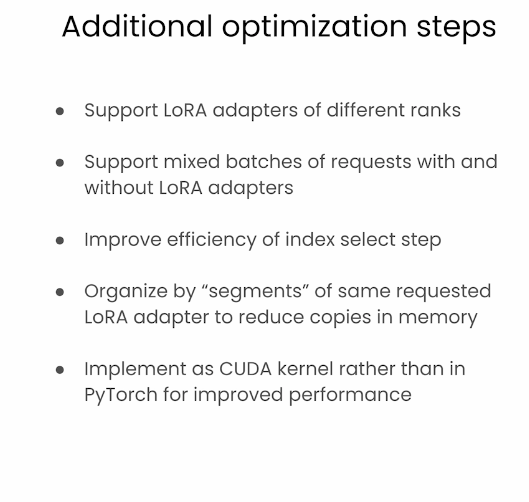